In [5]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sc
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from qlr import QuantileLinearRegression

import os

In [6]:
def elapsedtime_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1])
#because x264 output is "m:s", where m is the number of minutes and s the number of seconds 

res_dir = "../../data/res_ugc/"

v_names = sorted(os.listdir(res_dir)) # so we keep the same ids between two launches

listVideo = []

for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    assert data.shape == (201,36) or data.shape == (201,34), v
    listVideo.append(data)

In [7]:
#our variable of interest
predDimension = "fps"

# RQ1 - Input sensitivity

## RQ1.1 - Do the same options have the same effect on all inputs?

In [8]:
nbVideos = len(listVideo)
corrSpearman= [[0 for x in range(nbVideos)] for y in range(nbVideos)]

for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrSpearman[i][j] = 1
        else:
            corrSpearman[i][j] = sc.spearmanr(listVideo[i][predDimension],
                                            listVideo[j][predDimension]).correlation

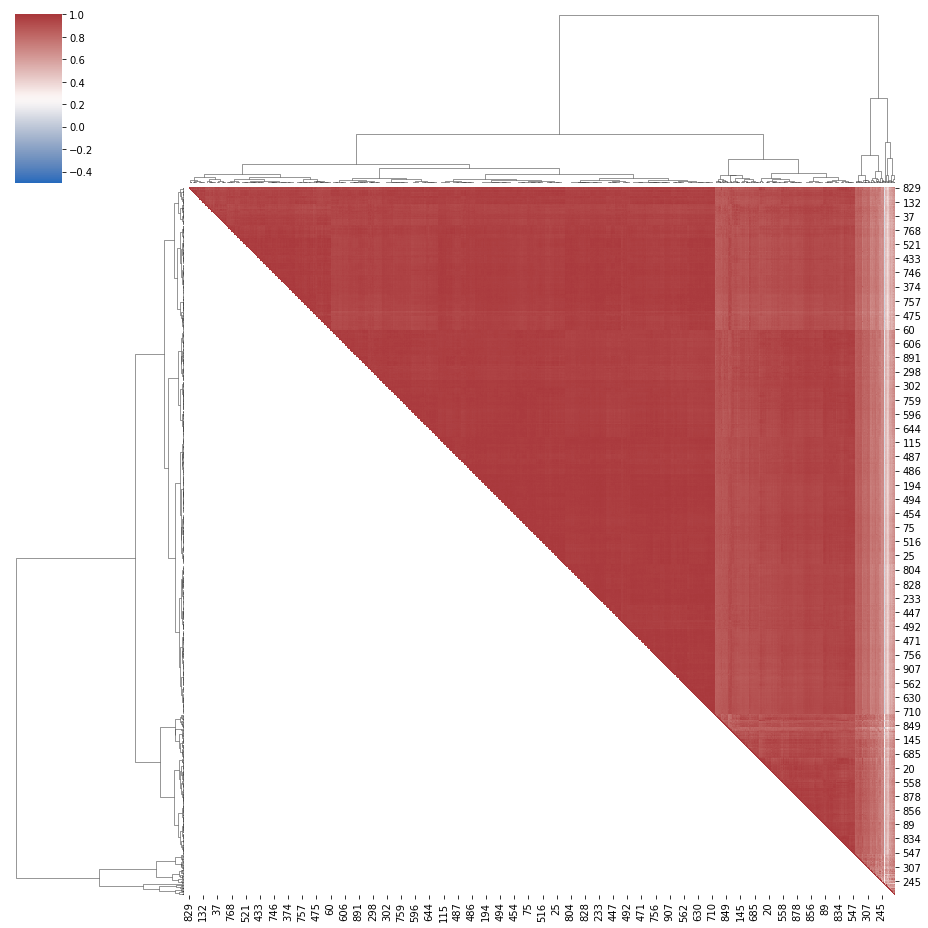

In [28]:
result_dir = "../results/"

def plot_correlationmatrix_dendogram(corr, img_name, ticks, method= 'ward', div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>j:
                mask[order[i]][order[j]] = True
    
    sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks}, vmin =-0.5)
    plt.savefig(result_dir+img_name)
    plt.show()
    
    return cut_tree(links, n_clusters = 3)

group_no_ordered = plot_correlationmatrix_dendogram(corrSpearman, 
                                 "corrmatrix-ugc-dendo-Spearman-" + predDimension + ".png",
                                 [k/5 for k in np.arange(-10,10,1)], method='ward')

In [10]:
map_group = [1, 2, 0]

def f(gr):
    return map_group[int(gr)]

groups = np.array([*map(f, group_no_ordered)],int)

sum(groups==0)
sum(groups==1)
sum(groups==2)

39

In [11]:
corrDescription = [corrSpearman[i][j] for i in range(nbVideos) for j in range(nbVideos) if i >j]
pd.Series(corrDescription).describe()

count    450775.000000
mean          0.925205
std           0.094985
min           0.005051
25%           0.921212
50%           0.955909
75%           0.972997
max           0.996437
dtype: float64

In [12]:
def plot_simple_correlationmatrix_dendogram(corr, img_name, ticks, id_names, method='ward'):

    df = pd.DataFrame(corr)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(shortnbVideos):
        for j in range(shortnbVideos):
            if i>j:
                mask[i][j] = True
    fig = plt.figure(figsize=(10, 8.5))
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(df, cmap="vlag", mask=mask,
               linewidths=.75, cbar_kws={"ticks":ticks})
    plt.yticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.xticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.savefig(result_dir+img_name)
    plt.show()

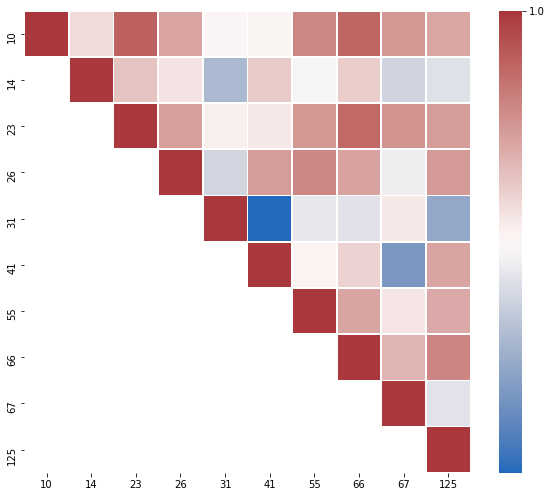

In [13]:
id_short = [10, 14, 23, 26, 31, 41, 55, 66, 67, 125]
short_v_names = [v_names[k] for k in id_short]

shortlistVideo = []
for v in short_v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    shortlistVideo.append(data)
    
shortnbVideos = len(shortlistVideo)

shortcorrSpearman= [[0 for x in range(shortnbVideos)] for y in range(shortnbVideos)]


for i in range(shortnbVideos):
    for j in range(shortnbVideos):
        if (i == j):
            shortcorrSpearman[i][j] = 1
        else:
            shortcorrSpearman[i][j] = sc.spearmanr(listVideo[id_short[i]][predDimension],listVideo[id_short[j]][predDimension]).correlation

plot_simple_correlationmatrix_dendogram(shortcorrSpearman, 
                     "corrmatrix-ugc-dendo-Spearman-short-" + predDimension + ".png", 
                     [k/5 for k in np.arange(-10,10,1)],
                                      id_short)

# RQ1-2

### Shortlist

In [14]:
id_short

[10, 14, 23, 26, 31, 41, 55, 66, 67, 125]

In [15]:
shortlistVideo[0] # video 10

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,usertime,systemtime,elapsedtime,cpu,frames,fps,kbs,ssim,ssimdb,etime
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,8.69,0.92,0:01.75,549,480,379.18,7675.34,NaN,NaN,1.75
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,29.88,1.56,0:04.08,770,480,137.35,2722.25,NaN,NaN,4.08
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,26.00,1.58,0:03.04,905,480,194.98,3179.35,NaN,NaN,3.04
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,32.80,1.37,0:02.89,1181,480,206.63,3142.93,NaN,NaN,2.89
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,39.70,1.41,0:03.29,1249,480,176.69,2579.38,NaN,NaN,3.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,24.80,1.67,0:03.55,745,480,160.70,2747.42,NaN,NaN,3.55
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,21.85,1.59,0:03.06,766,480,192.69,2805.80,NaN,NaN,3.06
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,32.95,1.42,0:03.45,996,480,166.61,2582.37,NaN,NaN,3.45
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,26.68,1.56,0:02.76,1022,480,218.91,3379.49,NaN,NaN,2.76


In [16]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

categorial = ['analyse', 'me', 'direct']

def compute_Importances(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listImportances = []

    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')

        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = RandomForestRegressor(n_estimators=200)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        clf.fit(X,y)

        listImportances.append(clf.feature_importances_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').transpose().drop(['open_gop','qpmax'],axis=1)
    return res

res = compute_Importances(shortlistVideo, id_short)
res.to_csv("../results/shortlist_features_importances"+predDimension+".csv")

### Boxplot

In [17]:
res = compute_Importances(listVideo)

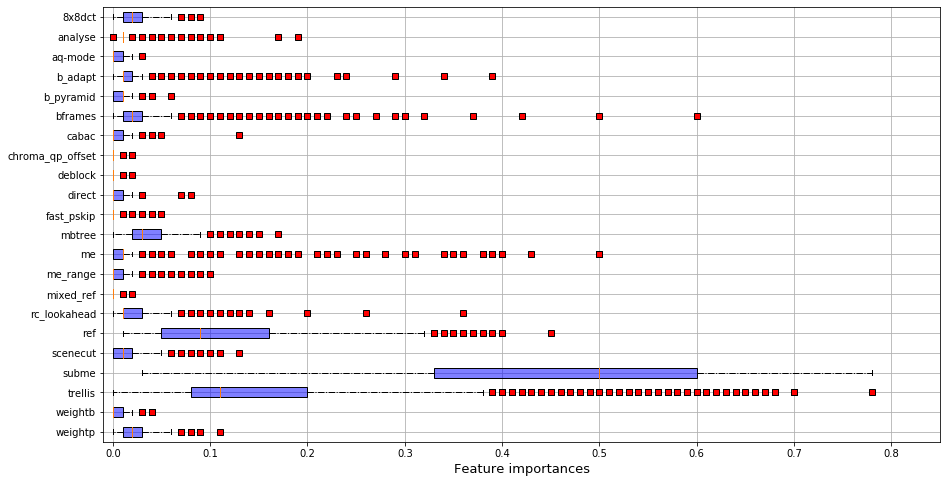

In [18]:
def boxplot_imp(res, xlim = None, criteria = 'max', name = None):
    if criteria == 'max':
        listImp = [(np.percentile(res[col],75), res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'range':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'name':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[2], reverse=True)

    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel('Feature importances',size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if name:
        plt.savefig(name)
    plt.show()
    
boxplot_imp(res, xlim = (-0.01,0.85),
            criteria = 'name', 
            name = "../group_paper/boxplot_features_imp_rf_"+predDimension+".png")

### Regression

In [19]:
def compute_poly(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    #listFeatures = ['subme','aq-mode','mbtree','cabac']
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    for n in names:
        final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = LinearRegression()
        X = df.drop([predDimension],axis=1)

        y = df[predDimension]
        #poly = PolynomialFeatures(degree=1, interaction_only = False, include_bias = True)    
        #X_interact = pd.DataFrame(poly.fit_transform(X))#, columns=final_names)
        #kept_names = ['subme','aq-mode','mbtree','cabac','cabac*mbtree','aq-mode*subme','cabac*subme']
        clf.fit(X,y)
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').drop(['open_gop','qpmax']).transpose()
    return res

res = compute_poly(listVideo)
res.to_csv("../results/list_features_importances_poly_"+predDimension+".csv")
res

features,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,bframes,b_pyramid,b_adapt,direct,weightb,weightp,scenecut,rc_lookahead,mbtree,aq-mode
video_0,-0.01,-0.10,-0.01,-0.03,-0.09,-0.23,0.09,-0.09,-0.15,-0.03,...,-0.23,-0.17,-0.23,0.06,0.21,-0.00,-0.02,0.03,-0.18,-0.05
video_1,0.02,-0.14,-0.00,-0.06,-0.09,-0.48,-0.03,0.01,-0.24,-0.09,...,-0.14,-0.03,-0.01,-0.02,0.01,-0.00,-0.03,0.03,-0.07,-0.01
video_2,0.03,-0.16,-0.02,-0.05,-0.10,-0.42,-0.01,-0.01,-0.34,-0.06,...,0.01,-0.12,0.01,-0.01,0.10,-0.01,-0.06,-0.00,-0.12,-0.01
video_3,0.01,-0.11,-0.01,-0.06,-0.08,-0.50,-0.02,0.00,-0.22,-0.10,...,-0.05,-0.02,-0.01,-0.02,-0.05,-0.03,-0.01,0.01,-0.13,-0.03
video_4,0.04,-0.14,-0.01,-0.04,-0.07,-0.43,-0.02,-0.02,-0.33,-0.07,...,-0.00,-0.07,-0.00,-0.01,0.04,-0.00,-0.03,-0.00,-0.10,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video_945,0.07,-0.19,-0.01,-0.03,-0.07,-0.41,0.02,-0.03,-0.37,-0.04,...,-0.00,-0.15,-0.03,0.02,0.12,0.02,-0.04,0.00,-0.06,0.00
video_946,0.01,-0.10,0.01,-0.02,-0.08,-0.45,-0.10,0.05,-0.32,-0.14,...,-0.05,0.04,0.13,-0.01,-0.10,-0.01,-0.02,-0.00,-0.14,-0.03
video_947,0.03,-0.11,-0.01,-0.05,-0.07,-0.50,-0.05,0.04,-0.26,-0.09,...,-0.07,-0.04,0.01,-0.03,-0.05,0.01,0.01,-0.00,-0.09,-0.05
video_948,-0.02,-0.08,0.00,-0.07,-0.09,-0.49,-0.06,0.04,-0.14,-0.14,...,-0.05,0.04,0.20,-0.04,-0.20,-0.02,-0.18,-0.00,-0.09,-0.06


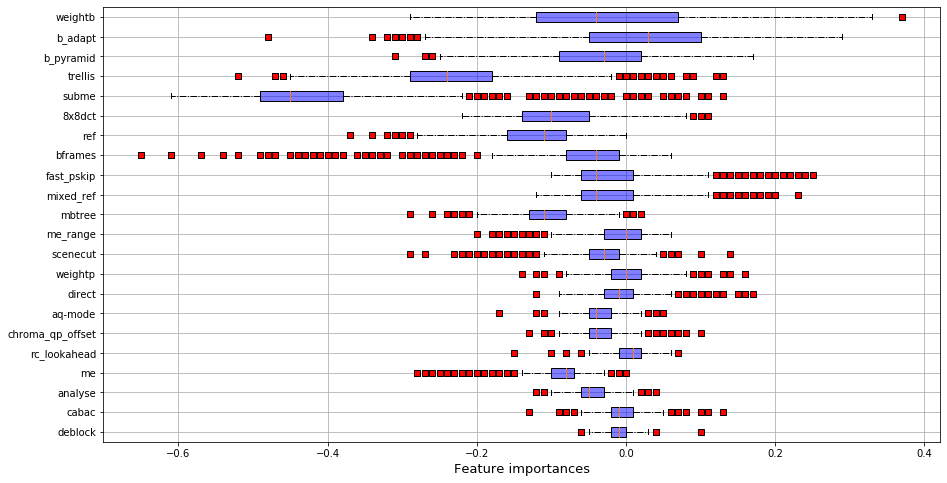

In [20]:
boxplot_imp(res, criteria ='range', name ="../group_paper/boxplot_features_imp_linear_"+predDimension+".png")

# RQ2

## RQ2.1 - Group of performances

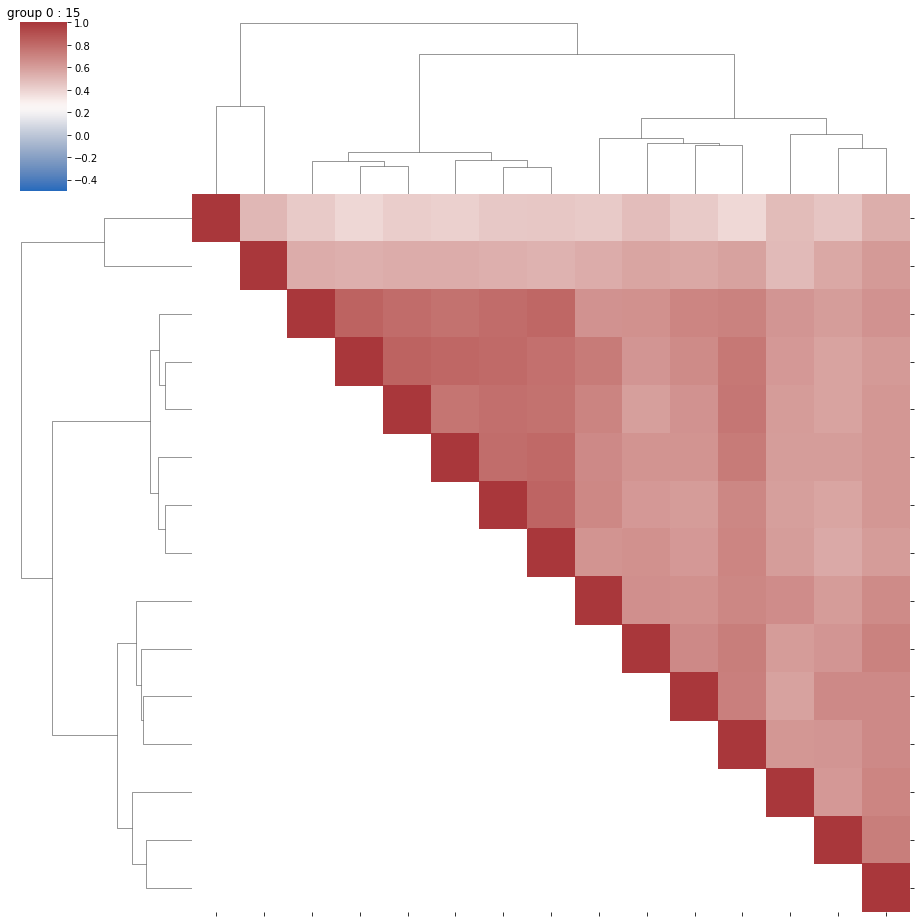

count    105.000000
mean       0.633228
std        0.107270
min        0.384018
25%        0.576507
50%        0.631524
75%        0.697078
max        0.835280
dtype: float64


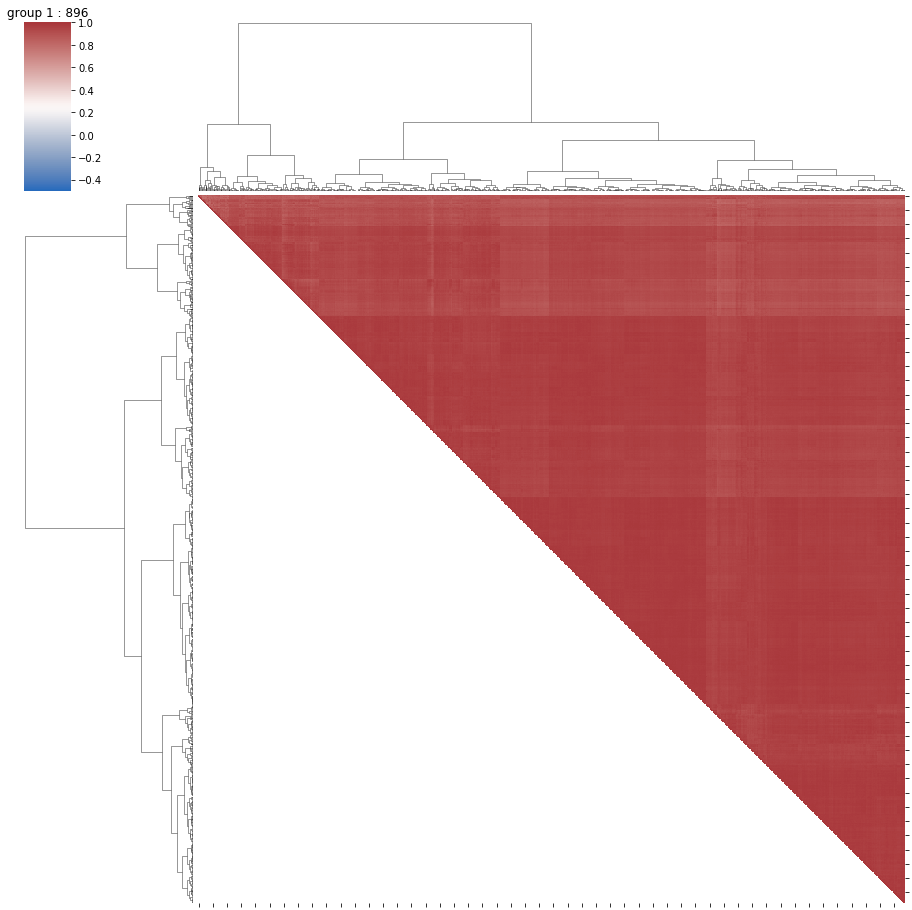

count    400960.000000
mean          0.952126
std           0.029457
min           0.746158
25%           0.936815
50%           0.960420
75%           0.974537
max           0.996437
dtype: float64


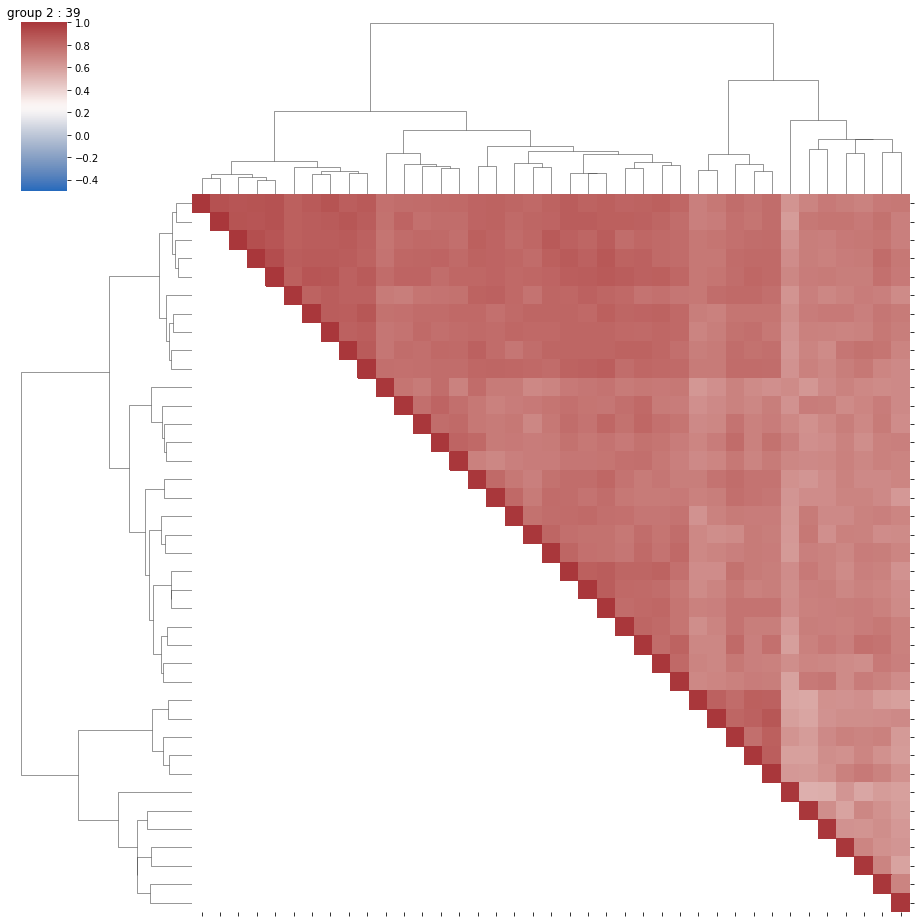

count    741.000000
mean       0.754152
std        0.067906
min        0.532387
25%        0.709117
50%        0.755396
75%        0.806114
max        0.913140
dtype: float64


In [21]:
def plot_corr_matrix(corr, method = 'ward', title=''):

    df = pd.DataFrame(corr)
    
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i>j:
                mask[order[i]][order[j]] = True
    
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), vmin=-0.5)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    plt.title(title)
    plt.show()
    
    corrDescription = [corr[i][j] for i in range(len(corr)) for j in range(len(corr)) if i >j]
    return pd.Series(corrDescription).describe()

def plot_group(group_index):
    ind = np.array([k for k in range(len(corrSpearman)) if groups[k] == group_index], dtype=int)
    group = np.copy([[corrSpearman[k][j] for j in ind] for k in ind])
    print(plot_corr_matrix(group,title="group "+str(group_index)+" : "+str(len(group))))

for i in range(3):
    plot_group(i)

## Summary per group

In [22]:
meta = pd.read_csv("../ugc_meta/all_features.csv").set_index('FILENAME')
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
del meta['NOISE_DMOS']
meta = meta.fillna(0)
cat_tab = pd.Series(meta['category'].values).unique()
meta['video_category'] = [np.where(cat_tab==meta['category'][i])[0][0] for i in range(len(meta['category']))]
del meta['category']
for col in meta.columns:#[:len(meta.columns)-1]:
    inter = np.array(meta[col],float)
    meta[col] = (inter-np.mean(inter))/np.std(inter)
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))])[1:],
              'perf_group' : np.array([k for k in groups])[1:]}).set_index('FILENAME')
meta_perf = perf.join(meta)
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-05f8,1,0.843640,0.742227,0.380890,0.330315,-0.147062,0.443113,2.546727,2.208462,-1.618994
Animation_1080P-0c4f,1,-0.656518,-0.377309,0.380890,0.330315,0.422696,-0.963894,1.055535,-1.232585,-1.618994
Animation_1080P-0cdf,1,-0.294941,-0.059125,0.380890,0.330315,-0.028411,0.429840,-0.102867,-0.448165,-1.618994
Animation_1080P-18f5,1,-0.479576,-0.377309,0.380890,0.330315,1.289667,-0.959469,-0.050889,0.193239,-1.618994
Animation_1080P-209f,1,6.282675,-0.377309,0.380890,0.330315,2.315231,-1.512538,-0.622865,-1.232585,-1.618994
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,1,-0.679597,-0.377309,-0.241046,-0.334452,0.979531,-1.415198,-0.652628,0.457602,1.494285
Vlog_720P-5d08,1,-0.679597,-0.377309,-0.773579,-0.334452,3.258561,-0.304636,-0.437382,-0.157800,1.494285
Vlog_720P-60f8,1,0.443598,0.624381,-0.241046,-0.334452,0.234735,-0.043587,-0.364052,-0.149132,1.494285


In [23]:
meta_perf['str_video_cat'] = [str(meta_perf.index[i]).split('_')[0] for i in range(meta_perf.shape[0])]
total_cat = meta_perf.groupby('str_video_cat').count()['perf_group']
group_perf = np.array([gr for gr in groups])
group_perf

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [24]:
def summary_group(id_group):
            
    id_list = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    v_names_group = [v_names[i][:-4] for i in range(len(v_names)) if i in id_list]
    listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
    
    print('Group '+str(id_group)+' : '+str(len(listVideoGroup))+' videos!')
    
    print('\n')

    # features importances
    boxplot_imp(compute_Importances(listVideoGroup), criteria = 'name', xlim= (0, 1),
               name ="../results/boxplot_imp_group"+str(id_group)+".png")

    # features effects
    boxplot_imp(compute_poly(listVideoGroup), criteria = 'name', xlim = (-1, 1),
               name ="../results/boxplot_effect_group"+str(id_group)+".png")

    print('\n')

    interest_var = ['cpu', 'etime', 'fps', 'kbs', 'size']

    for iv in interest_var:
        pred = [np.mean(lv[iv]) for lv in listVideoGroup]
        print('Mean '+iv+' in the group: '+str(np.round(np.mean(pred),1)))

    print('\n')

    # percentage of the videos present in the group par category

    meta_perf_group = meta_perf.query('perf_group=='+str(id_group))
    meta_perf_group['str_video_cat'] = [str(meta_perf_group.index[i]).split('_')[0] for i in range(meta_perf_group.shape[0])]
    val_group = meta_perf_group.groupby('str_video_cat').count()['perf_group']
    df_res_cat_group = pd.DataFrame({'val': val_group, 'total': total_cat})
    print(df_res_cat_group['val']/df_res_cat_group['total'])

    print('\n')

    # Mean of the videos of the group per properties

    for col in meta_perf_group.columns:
        if col not in ['str_video_cat', 'video_category']:
            print('Mean '+col+' : '+str(meta_perf_group[col].mean()))

    print('\n')

    corrGroup = np.array([corrSpearman[i][j] for i in range(len(corrSpearman)) if i in id_list 
                 for j in range(len(corrSpearman)) if j in id_list],float)

    print("Correlations intra-group: \n" + str(pd.Series(corrGroup).describe().iloc[[1,5]])+'\n')

Group 0 : 15 videos!




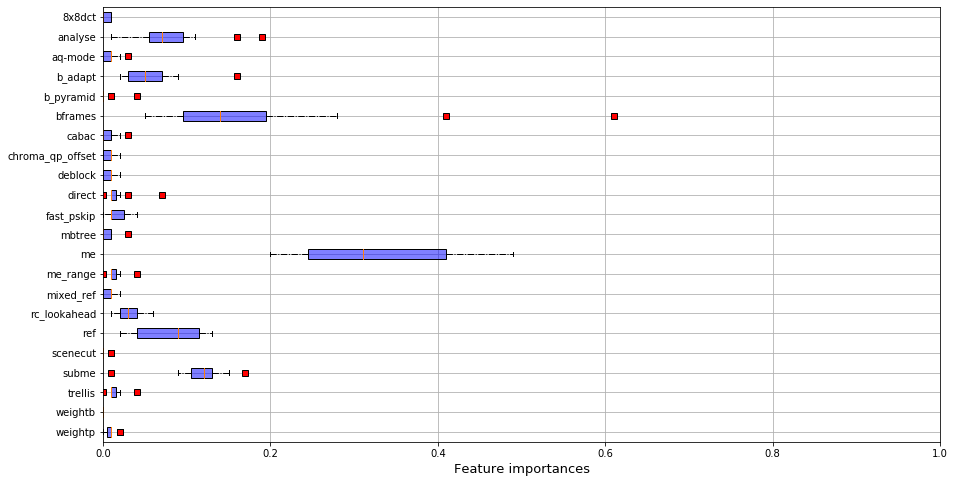

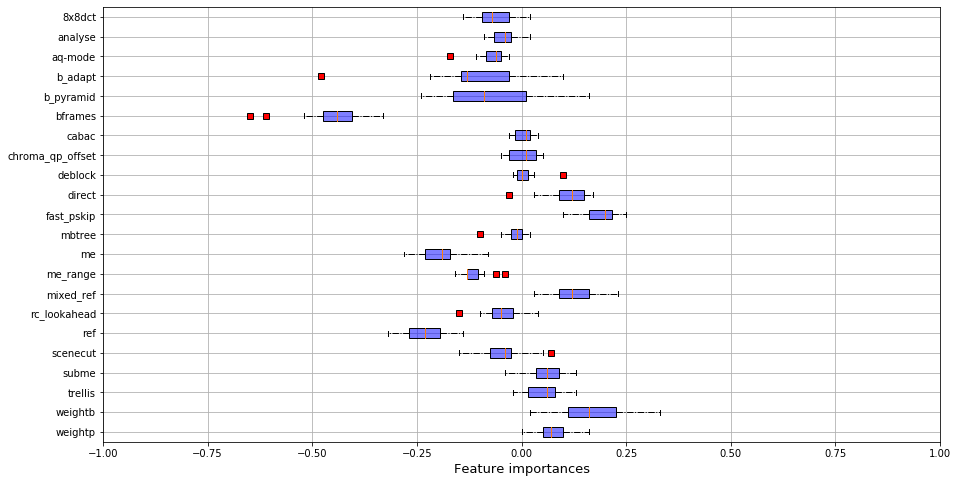



Mean cpu in the group: 608.1
Mean etime in the group: 133.0
Mean fps in the group: 10.4
Mean kbs in the group: 22969.9
Mean size in the group: 57411331.1


Animation              NaN
CoverSong              NaN
Gaming                 NaN
HDR               0.288462
HowTo                  NaN
Lecture                NaN
LiveMusic              NaN
LyricVideo             NaN
MusicVideo             NaN
NewsClip               NaN
Sports                 NaN
TelevisionClip         NaN
VR                     NaN
VerticalVideo          NaN
Vlog                   NaN
dtype: float64


Mean perf_group : 0.0
Mean SLEEQ_DMOS : 0.8215865905365151
Mean BANDING_DMOS : 0.13021386979319585
Mean WIDTH : 2.2466975990572786
Mean HEIGHT : 2.324616229477876
Mean SPATIAL_COMPLEXITY : -0.688468213523051
Mean TEMPORAL_COMPLEXITY : -0.0922572754485418
Mean CHUNK_COMPLEXITY_VARIATION : -0.43620320172195787
Mean COLOR_COMPLEXITY : -0.29705954798404405


Correlations intra-group: 
mean    0.657680
50%     0.636756
dt

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
summary_group(0)

Group 1 : 896 videos!




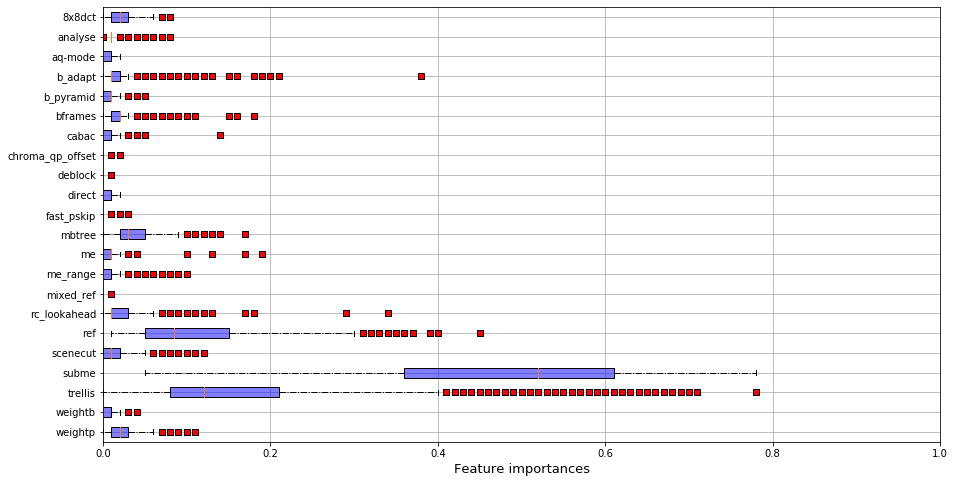

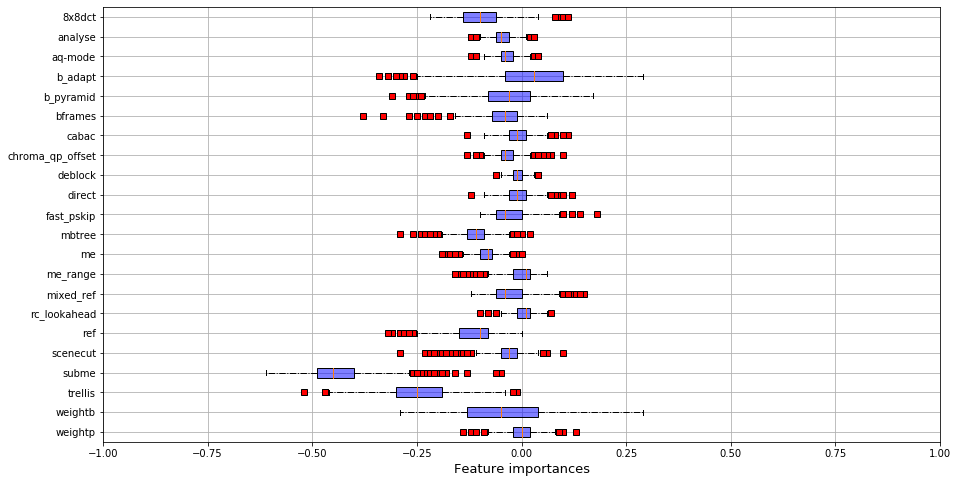



Mean cpu in the group: 977.5
Mean etime in the group: 7.9
Mean fps in the group: 441.8
Mean kbs in the group: 9420.3
Mean size in the group: 23273342.0


str_video_cat
Animation         1.000000
CoverSong         1.000000
Gaming            1.000000
HDR               0.057692
HowTo             0.988506
Lecture           1.000000
LiveMusic         1.000000
LyricVideo        1.000000
MusicVideo        1.000000
NewsClip          1.000000
Sports            1.000000
TelevisionClip    1.000000
VR                0.971429
VerticalVideo     0.973333
Vlog              1.000000
dtype: float64


Mean perf_group : 1.0
Mean SLEEQ_DMOS : -0.023980309271644372
Mean BANDING_DMOS : 0.03552015326947296
Mean WIDTH : -0.04681702178204547
Mean HEIGHT : -0.037452575181915866
Mean SPATIAL_COMPLEXITY : 0.01002524926522376
Mean TEMPORAL_COMPLEXITY : -0.0008346747517759351
Mean CHUNK_COMPLEXITY_VARIATION : 0.05347664024341069
Mean COLOR_COMPLEXITY : -0.008866713390668211




/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
mean    0.952179
50%     0.960457
dtype: float64



In [26]:
summary_group(1)

Group 2 : 39 videos!




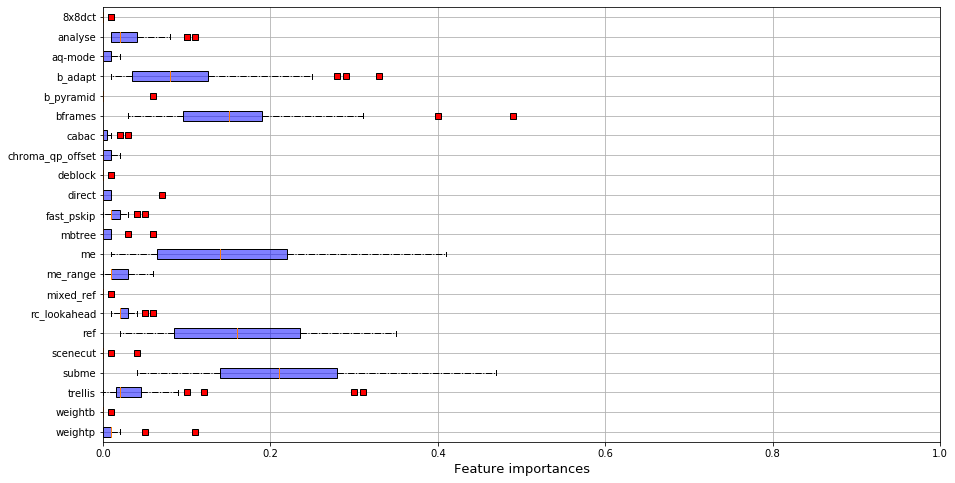

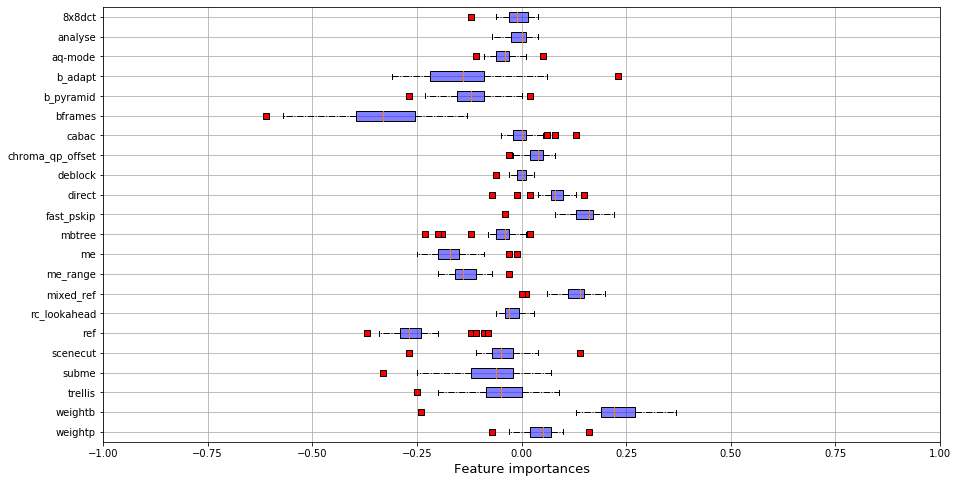



Mean cpu in the group: 692.9
Mean etime in the group: 45.9
Mean fps in the group: 54.2
Mean kbs in the group: 18528.3
Mean size in the group: 46082119.8


Animation              NaN
CoverSong              NaN
Gaming                 NaN
HDR               0.653846
HowTo             0.011494
Lecture                NaN
LiveMusic              NaN
LyricVideo             NaN
MusicVideo             NaN
NewsClip               NaN
Sports                 NaN
TelevisionClip         NaN
VR                0.028571
VerticalVideo     0.026667
Vlog                   NaN
dtype: float64


Mean perf_group : 2.0
Mean SLEEQ_DMOS : -0.17303506880669778
Mean BANDING_DMOS : -0.30509092522078857
Mean WIDTH : 0.9856826727426452
Mean HEIGHT : 0.9897791239973214
Mean SPATIAL_COMPLEXITY : -0.6963963223003958
Mean TEMPORAL_COMPLEXITY : 0.048647666696605266
Mean CHUNK_COMPLEXITY_VARIATION : -0.43584484577258353
Mean COLOR_COMPLEXITY : 0.736076732853525


Correlations intra-group: 
mean    0.760456
50%     0.759155


/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
summary_group(2)

In [88]:
group_perf
id_list_0 = [i for i in range(len(listVideo)) if group_perf[i]==0]
id_list_1 = [i for i in range(len(listVideo)) if group_perf[i]==1]
id_list_2 = [i for i in range(len(listVideo)) if group_perf[i]==2]

res = np.zeros(9).reshape(3,3)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res[0][1] = np.mean(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res[0][2] = np.mean(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res[1][2] = np.mean(tab)

print(res)

res_med = np.zeros(9).reshape(3,3)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res_med[0][1] = np.median(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res_med[0][2] = np.median(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res_med[1][2] = np.median(tab)

res_med

[[0.         0.10236622 0.39042802]
 [0.         0.         0.4402605 ]
 [0.         0.         0.        ]]


array([[0.        , 0.10941812, 0.42301883],
       [0.        , 0.        , 0.47749604],
       [0.        , 0.        , 0.        ]])

## Penalized regression

In [89]:
def compute_lasso_reg(listVid, id_short=None, sort_method = 'mean'):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    #for n in names:
    #    final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        for col in df.columns:
            if col not in categorial:
                if col != predDimension:
                    arr_col = np.array(df[col],int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        clf = ElasticNet(l1_ratio = 1, tol = 0.01)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        
        poly = PolynomialFeatures(degree=2, interaction_only = True, include_bias = True)
        
        X_interact = pd.DataFrame(poly.fit_transform(X), columns=final_names)
        
        clf.fit(X_interact,y)
        
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : final_names})
    
    cs = 100
    
    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = listImportances[id_video]
    
    res = res.set_index('features').transpose()
    
    feats = []
    for f in res.columns:
        if sort_method == 'mean':
            feats.append(np.mean(np.abs(res[f])))
        elif sort_method == 'max_abs':
            feats.append(np.max(np.abs(res[f])))
    
    return res[pd.Series(feats, res.columns).sort_values(ascending=False)[0:25].index]

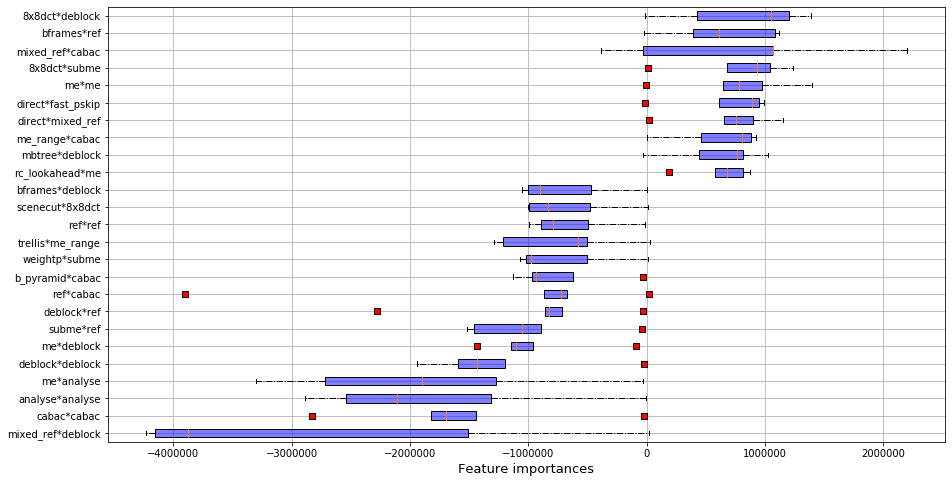

In [90]:
boxplot_imp(compute_lasso_reg(listVideo[0:5], sort_method = 'mean'))

### With dummification - Fixed values for features

In [91]:
vid = listVideo[0]

keep_features = ['cabac', 'ref', 'deblock', 'analyse', 'me', 'subme',
       'mixed_ref', 'me_range', 'trellis', '8x8dct', 'fast_pskip',
       'chroma_qp_offset', 'bframes', 'b_pyramid', 'b_adapt', 'direct',
       'weightb', 'open_gop', 'weightp', 'scenecut', 'rc_lookahead', 'mbtree',
       'qpmax', 'aq-mode']

dummies = pd.get_dummies(vid[keep_features], 
                   drop_first = False,
                   columns=keep_features)

X = pd.DataFrame(np.array(dummies, dtype=int))

poly = PolynomialFeatures(degree=2, interaction_only = True, include_bias = False)

dum_names = dummies.columns

X_interact = pd.DataFrame(np.array(poly.fit_transform(dummies),int))

names = []
for i in range(len(dum_names)):
    names.append(dum_names[i])
for i in range(len(dum_names)):
    for j in np.arange(i+1,len(dum_names), 1):
        names.append(dum_names[i] + " " + dum_names[j])

X_interact.columns = names
X_interact

,cabac_0,cabac_1,ref_1,ref_2,ref_3,ref_5,ref_7,ref_8,ref_16,deblock_0:0:0,...,mbtree_0 mbtree_1,mbtree_0 qpmax_69,mbtree_0 aq-mode_0,mbtree_0 aq-mode_1,mbtree_1 qpmax_69,mbtree_1 aq-mode_0,mbtree_1 aq-mode_1,qpmax_69 aq-mode_0,qpmax_69 aq-mode_1,aq-mode_0 aq-mode_1
0,1,0,1,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
197,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0
198,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
199,1,0,0,0,1,0,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0


In [92]:
def compute_lasso(id_group):
    id_video = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    keep_inter = []
    for idv in id_video:
        vid = listVideo[idv]
        regr = ElasticNet(l1_ratio = 1, tol = 0.01)
        regr.fit(X_interact, vid[predDimension])
        serie = pd.Series(np.abs(regr.coef_), names)
        keep_inter.append(np.array(serie.sort_values(ascending=False)[0:25].index, str))
    arr = np.array(keep_inter).reshape(-1,1)
    d = dict()
    for interact in arr:
        word = interact[0]
        if word not in d:
            d[word] = 1
        else:
            d[word] = d[word]+1
    res = pd.Series([d[w] for w in d.keys()], d.keys())
    return np.array(res.sort_values(ascending=False)[0:25].index, str)  

In [93]:
for t in range(3):
    print(np.sort(compute_lasso(t)))

['analyse_0:0' 'analyse_0:0 subme_1' 'analyse_0x3:0x3 bframes_0'
 'aq-mode_0' 'cabac_0' 'cabac_0 analyse_0x3:0x133' 'cabac_0 bframes_16'
 'cabac_0 ref_1' 'cabac_0 ref_16' 'cabac_0 ref_3' 'cabac_0 ref_5'
 'cabac_0 ref_8' 'cabac_0 subme_11' 'cabac_1 deblock_0:0:0'
 'cabac_1 scenecut_None' 'deblock_0:0:0' 'rc_lookahead_20' 'ref_1'
 'ref_16 subme_7' 'ref_2 subme_7' 'ref_3 analyse_0:0' 'scenecut_None'
 'subme_0' 'subme_2' 'subme_7']
['analyse_0:0 subme_1' 'aq-mode_0' 'bframes_0' 'cabac_0'
 'cabac_0 bframes_16' 'cabac_0 ref_1' 'cabac_0 ref_16' 'cabac_0 ref_3'
 'cabac_0 ref_5' 'cabac_0 subme_11' 'cabac_1 ref_7'
 'cabac_1 scenecut_None' 'mbtree_0' 'me_dia' 'me_hex subme_0' 'ref_1'
 'ref_2 subme_10' 'ref_3' 'ref_3 analyse_0x113:0x113' 'ref_7'
 'scenecut_None' 'subme_0' 'subme_1 rc_lookahead_10' 'subme_2' 'subme_6']
['analyse_0:0' 'analyse_0x3:0x3 bframes_0' 'b_pyramid_1' 'bframes_0'
 'cabac_0' 'cabac_0 bframes_16' 'cabac_0 ref_1' 'cabac_0 ref_16'
 'cabac_0 ref_3' 'cabac_0 ref_5' 'cabac_0 ref_8'

## Quantile regression

In [94]:
def compute_quantile_reg(listVid, id_short=None, quantile = 0.5):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        for col in df.columns:
            if col not in categorial:
                if col != predDimension:
                    arr_col = np.array(df[col],int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        if quantile:
            clf = QuantileLinearRegression(quantile=quantile)
        else:
            clf = QuantileLinearRegression()
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        
        clf.fit(X,y)
        
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : listFeatures})
    
    cs = 100
    
    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = listImportances[id_video]
    
    return res.set_index('features').transpose()

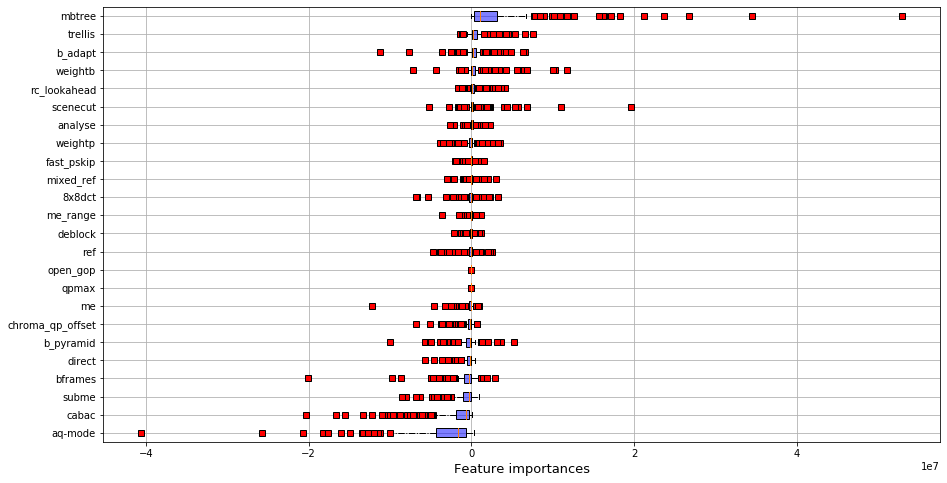

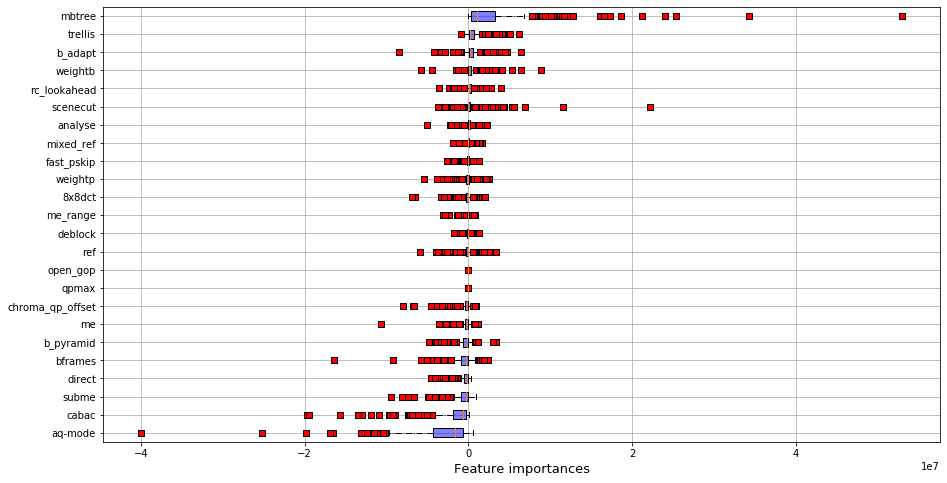

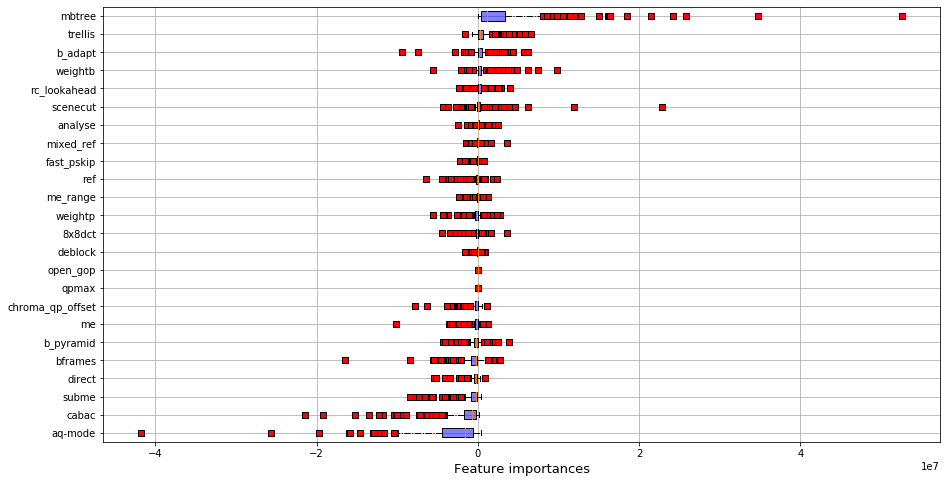

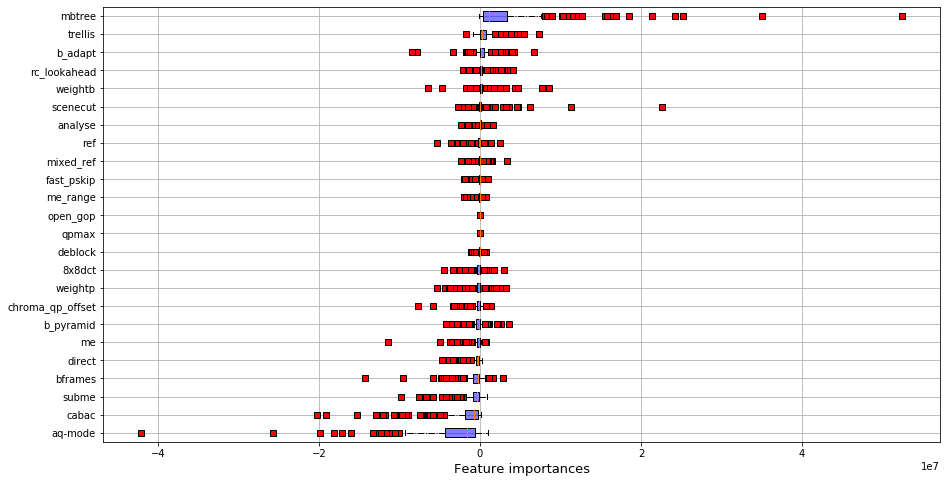

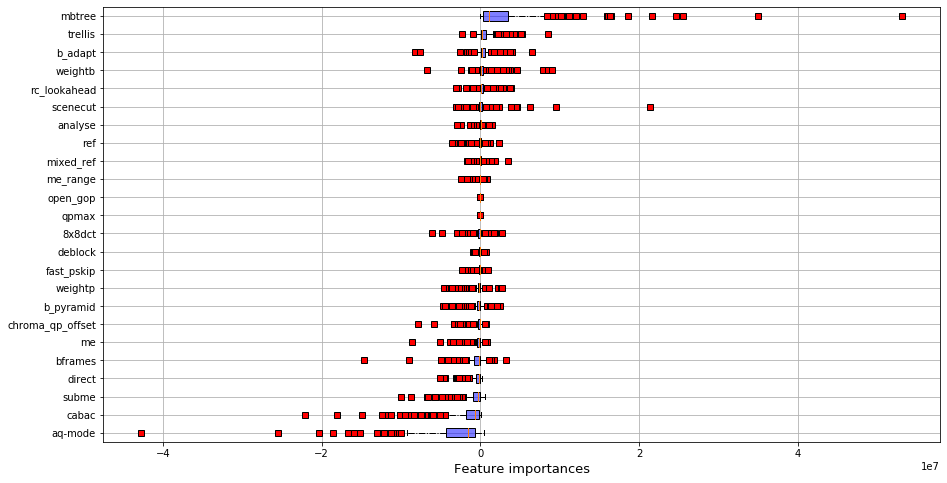

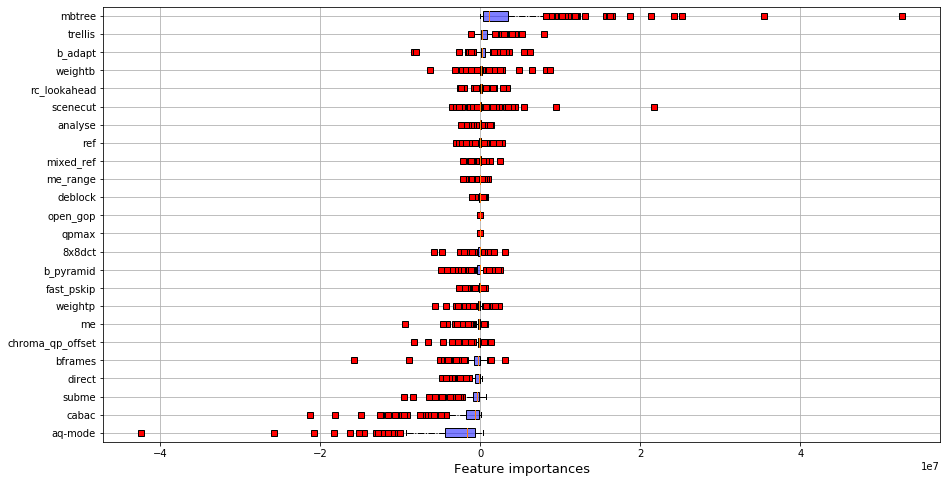

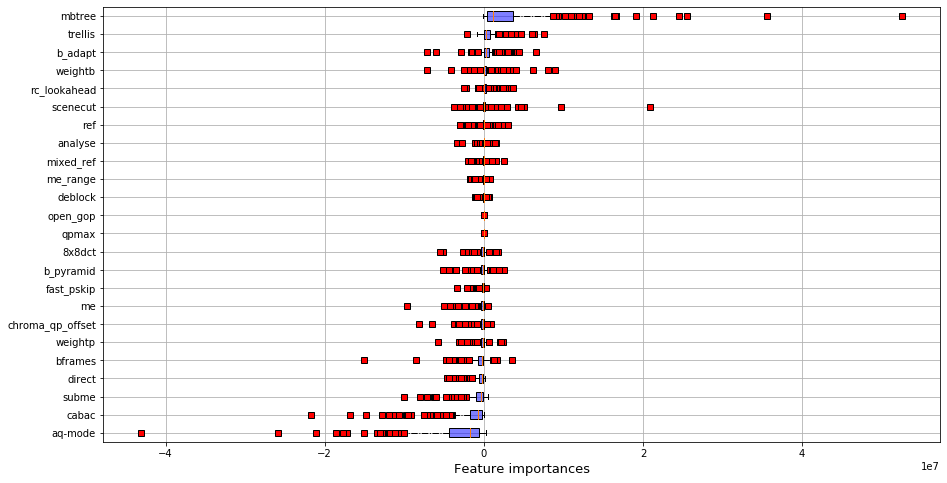

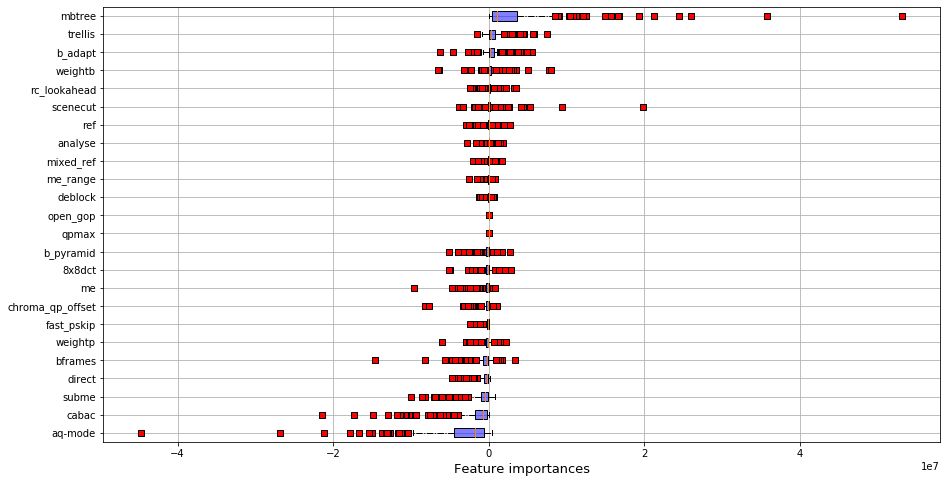

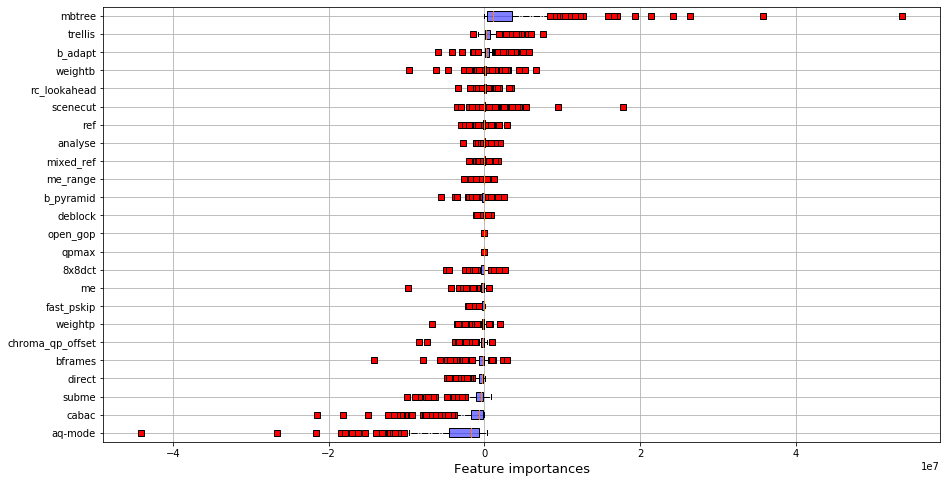

In [95]:
id_list = [i for i in range(len(listVideo)) if group_perf[i]==0]
listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
quantile = [0.1*k for k in np.arange(0.1,1,0.1)]
for q in quantile:
    boxplot_imp(compute_quantile_reg(listVideoGroup, quantile = q))

## RQ2.2 - Group classification

In [150]:
if 'str_video_cat' in meta_perf.columns:
    del meta_perf['str_video_cat']

accuracy = []

nbLaunches =10
for i in range(nbLaunches):
    X = np.array(meta_perf[[k for k in meta_perf.columns if k !='perf_group']], float)
    y = np.array(meta_perf['perf_group'], float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)


    conf = pd.crosstab(y_pred, y_test)#, colnames=[1,2,3], rownames=[1,2,3])
    val = np.sum(np.diag(conf))/len(y_test)
    accuracy.append(val)
    print('Test accuracy : '+ str(val))
    conf.columns = pd.Int64Index([1,2,3], dtype='int64', name='Observed')
    conf.index = pd.Int64Index([1,2,3], dtype='int64', name='Predicted')
    conf
print(np.mean(accuracy))
conf

Test accuracy : 0.772020725388601
Test accuracy : 0.689119170984456
Test accuracy : 0.7461139896373057
Test accuracy : 0.7305699481865285
Test accuracy : 0.7305699481865285
Test accuracy : 0.6735751295336787
Test accuracy : 0.7150259067357513
Test accuracy : 0.7357512953367875
Test accuracy : 0.7305699481865285
Test accuracy : 0.7409326424870466
0.7264248704663212


Observed,1,2,3
Predicted,,,
1,39,0,11
2,0,20,11
3,11,17,84


In [97]:
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-05f8,2,0.843640,0.742227,0.380890,0.330315,-0.147062,0.443113,2.546727,2.208462,-1.618994
Animation_1080P-0c4f,2,-0.656518,-0.377309,0.380890,0.330315,0.422696,-0.963894,1.055535,-1.232585,-1.618994
Animation_1080P-0cdf,0,-0.294941,-0.059125,0.380890,0.330315,-0.028411,0.429840,-0.102867,-0.448165,-1.618994
Animation_1080P-18f5,0,-0.479576,-0.377309,0.380890,0.330315,1.289667,-0.959469,-0.050889,0.193239,-1.618994
Animation_1080P-209f,2,6.282675,-0.377309,0.380890,0.330315,2.315231,-1.512538,-0.622865,-1.232585,-1.618994
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,2,-0.679597,-0.377309,-0.241046,-0.334452,0.979531,-1.415198,-0.652628,0.457602,1.494285
Vlog_720P-5d08,0,-0.679597,-0.377309,-0.773579,-0.334452,3.258561,-0.304636,-0.437382,-0.157800,1.494285
Vlog_720P-60f8,0,0.443598,0.624381,-0.241046,-0.334452,0.234735,-0.043587,-0.364052,-0.149132,1.494285


In [128]:
pd.DataFrame({'Random forest importance' : rf.feature_importances_,
              'name' : meta_perf.columns[1:]}).set_index('name')

,Random forest importance
name,
SLEEQ_DMOS,0.072091
BANDING_DMOS,0.046348
WIDTH,0.045705
HEIGHT,0.034997
SPATIAL_COMPLEXITY,0.289946
TEMPORAL_COMPLEXITY,0.209568
CHUNK_COMPLEXITY_VARIATION,0.148379
COLOR_COMPLEXITY,0.097515
video_category,0.055450


In [99]:
meta_perf.groupby(['perf_group']).mean()

,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
perf_group,,,,,,,,,
0,-0.078311,-0.229780,-0.116496,-0.135671,0.804723,0.289698,0.717640,-0.082420,0.043716
1,0.081870,0.122683,0.607173,0.537666,-0.891920,0.661285,-0.297182,0.188592,-0.008223
2,-0.071027,0.103646,-0.271269,-0.301448,-0.223278,-0.461625,-0.203138,0.048928,-0.386508


## RQ2.3 - Auto-tune

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
print(tf.__version__)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

def get_y(x):
    return 10 + x*x

def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3


X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step



# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})
    
    if i%1000 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()

In [ ]:
import numpy as np
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

# PCA 

In [ ]:

df_std_meta = meta[['SPATIAL_COMPLEXITY', 'TEMPORAL_COMPLEXITY', 
                          'CHUNK_COMPLEXITY_VARIATION','COLOR_COMPLEXITY']]
std_meta = np.array(df_std_meta)

kmeans = KMeans(n_clusters=3)
kmeans.fit(std_meta)
meta['clusters'] = kmeans.labels_
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
meta['quality']=[str(meta.index[i]).split('_')[1].split('-')[0] for i in range(meta.shape[0])]


pca = PCA(n_components=2, svd_solver='full')
tab = pca.fit_transform(std_meta)
x = [tab[i][0] for i in range(len(tab))]
y = [tab[i][1] for i in range(len(tab))]

col = ['gray','red','green','black']

plt.figure(figsize=(16,8))
plt.title("Axis (PCA) Color Kmeans classes")
plt.scatter(x, y, color = [col[k] for k in meta['clusters']])
lab=np.array(meta.index,str)
#for i in range(len(x)):
#    plt.text(x[i], y[i], lab[i])
plt.show()

In [ ]:
pd.crosstab(meta_perf['perf_group'], meta['clusters'])

In [ ]:
meta_perf